In [ ]:
testing_mode = 0 #0 to run for all subjects
saving_figures = 0 # No=0, Yes=1
version_label = 'v4'
binarization_thresh='50'
version='notebook-05-pattern-similarity_%s_thresh-%s' % (version_label,binarization_thresh)

if testing_mode == 1:
    subject_list = [104,105,106,107,108]
elif testing_mode == 0:
    subject_list = [104,105,106,107,108,109,110,111,112,114,115,116,117,119,120,122,125,126,127,129,132,133,134,135,137,139,140,141,
               142,143,144,145,146,147,148,149,150,151,152,153,155,156,158,159,160,161,162,164,165,166,168,169,170,172,173,174,175,
               176,177,178,179,180,181,182,184,185,186,187,188]

n_subjects = len(subject_list)
print('n_subjects:', n_subjects)
print('')

In [ ]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os
#import os.path
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.io as spio
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statannot import add_stat_annotation
#import pingouin as pg
import plotly.express as px

%matplotlib inline 
%autosave 5

In [ ]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
#print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The seaborn version is {}.'.format(sns.__version__))
# note: update to seaborn v0.12 to use SE for error bars

#assert sklearn.__version__== '0.21.3'
#assert python_version()== '3.7.6'

In [ ]:
# directories
svd_dir='/jukebox/norman/emcdevitt/studies/SVD/'
analysis_dir=svd_dir + 'data/mainanalysis/'
output_dir=analysis_dir + 'output/%s/' % version
save_figs=analysis_dir + 'figures/manuscript/%s/' % version

# make out_dir if it doesn't exist
if os.path.exists(save_figs)==False:
    os.mkdir(save_figs) 

print('data loaded from: %s' % (output_dir))
print('')
print('figures saved to: %s' % (save_figs))

# label dictionaries
conditions = {1:"vio", 2:"nonvio", 3:"vio-nonvio"}
groups = {0:"wake", 1:"NREM", 2:"REM"}
categories = {0:"rest", 1:"face", 2:"scene", 3:"object"}

mask_list=['left_CA2+3+DG_1.5mm', 'right_CA2+3+DG_1.5mm', 'bilateral_CA2+3+DG_1.5mm',
           'left_CA2+3_1.5mm', 'right_CA2+3_1.5mm', 'bilateral_CA2+3_1.5mm',
           'left_DG_1.5mm', 'right_DG_1.5mm', 'bilateral_DG_1.5mm',
           'left_CA1_1.5mm', 'right_CA1_1.5mm', 'bilateral_CA1_1.5mm']

In [ ]:
def main(in_file,sub):
    #print(in_file)
    print (sub+" file exists: "+str(path.exists(in_file)))

print('check that pattern_similarity_analyses.npz file exists')
for subject in range(0, n_subjects):
    this_sub = int(subject_list[subject])
    sub = 'sub-%s' % (this_sub)
    in_file = output_dir + '%s_pattern_similarity_analyses.npz' % (sub)
    if __name__== "__main__":
        main(in_file,sub)

print('')
print('check that variables actually contain info')
for subject in range(0, n_subjects):
    this_sub = int(subject_list[subject])
    sub = 'sub-%s' % (this_sub)
    in_file = output_dir + '%s_pattern_similarity_analyses.npz' % (sub)
    in_data = np.load(in_file, allow_pickle=True)
    display(in_data['differentiation'])

In [ ]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    #data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [ ]:
pd.set_option('display.max_rows', 10)
# get subject group info (wake, NREM, REM)
in_file=(analysis_dir + 'subjInfo.mat')
print('loading subject group info from:', in_file)
data = loadmat(in_file)
group_label = data['subjInfo'] #dictionary
group_label_df = pd.DataFrame.from_dict(group_label)
group_label_df

## Load data

#### Dictionaries saved to each subject's pattern_similarity_analyses.npz file
- **image_info:** for each scene pair, gives info about condition, category, imgIDs, and trial indices
- **pairwise_data:** for each scene pair, gives raw correlation values (Pearson's r) for each comparison
- **differentiation:** raw preApostB correlation values (Fisher's z and Pearson's r) for each condition (vio, nonvio, vio-nonvio) and each mask
- **Bprediction_reward:** postB correlated with familiarization and reward trials for each condition and each mask
- **Bprediction_diff:** B prediction during violation events correlated with differentiation
- **Bevidence_faces:** B evidence during postface snapshots correlated with differentiation
- **Bprediction_reward_diff:** B prediction during reward learning correlated with differentiation
- **image_info_differentiation_permutation:** info about shuffled pairings for each iteration of differentiation randomization analysis
- **differentiation_shuffled_values:** preApostBshuffled values for each condition, each iteration, each mask
- **differentiation_zscores:** for each mask, the observed vio-nonvio values, the shuffled mean and std, and the subject's z-score
- **image_info_Bpredict_permutation:** info about shuffled pairings for each iteration of Bpredict-diff randomization analysis
- **BpredictDiff_corr_shuffled_values:** Bprediction-shuffled correlated with differentiation for each iteration, each mask
- **BpredictDiff_corr_zscores:** for each mask, the observed BpredictDiff values, the shuffled mean and std, and the subject's z-score

In [ ]:
# Get data for all subjects for variables of interest
differentiation = pd.DataFrame() #empty dataframe
differentiation_zscores = pd.DataFrame()
Bprediction_diff = pd.DataFrame()
Bprediction_diff_zscores = pd.DataFrame()
Bevidence_faces = pd.DataFrame() #empty dataframe

# loop through each subject and load data
for subject in range(0, n_subjects):
    this_sub = int(subject_list[subject])
    #print(this_sub)
    sub = 'sub-%s' % (this_sub)
    in_file = output_dir + '%s_pattern_similarity_analyses.npz' % (sub)
    in_data = np.load(in_file, allow_pickle=True)
    #display(in_data['differentiation'])
    
    # get this subject's sleep/wake group label
    group = []
    group = group_label_df['cond'].loc[group_label_df['id']=='%s' % this_sub]
    group = group.item()
    
    # differentiation
    select_data = in_data['differentiation'].item()
    select_data = pd.DataFrame.from_dict(select_data) #convert to dataframe
    select_data.insert(0, "subjectID", this_sub) #insert a row with subjectID
    select_data.insert(1, "group", group) #insert a row with sleep condition
    differentiation = pd.concat([differentiation, select_data], ignore_index=True) #concatenate with existing dataframe
    
    # differentiation -- randomization analysis
    select_data = in_data['differentiation_zscores'].item()
    select_data = pd.DataFrame.from_dict(select_data) #convert to dataframe
    select_data.insert(0, "subjectID", this_sub) #insert a row with subjectID
    select_data.insert(1, "group", group) #insert a row with sleep condition
    differentiation_zscores = pd.concat([differentiation_zscores, select_data], ignore_index=True)
    
    # Bprediction correlated with differentiation
    select_data = in_data['Bprediction_diff'].item()
    select_data = pd.DataFrame.from_dict(select_data) #convert to dataframe
    select_data.insert(0, "subjectID", this_sub) #insert a row with subjectID
    select_data.insert(1, "group", group) #insert a row with sleep condition
    Bprediction_diff = pd.concat([Bprediction_diff, select_data], ignore_index=True)

    # Bprediction correlated with differentiation -- randomization analysis
    select_data = in_data['BpredictDiff_corr_zscores'].item()
    select_data = pd.DataFrame.from_dict(select_data) #convert to dataframe
    select_data.insert(0, "subjectID", this_sub) #insert a row with subjectID
    select_data.insert(1, "group", group) #insert a row with sleep condition
    Bprediction_diff_zscores = pd.concat([Bprediction_diff_zscores, select_data], ignore_index=True)

    # Bevidence_faces
    select_data = in_data['Bevidence_faces'].item()
    select_data = pd.DataFrame.from_dict(select_data) #convert to dataframe
    select_data.insert(0, "subjectID", this_sub) #insert a row with subjectID
    select_data.insert(1, "group", group) #insert a row with sleep condition
    Bevidence_faces = pd.concat([Bevidence_faces, select_data], ignore_index=True) #concatenate with existing dataframe
    
assert differentiation.shape[0] == n_subjects*len(mask_list)*3 #3 conditions (vio, nonvio, vio-nonvio)
assert differentiation_zscores.shape[0] == n_subjects*len(mask_list)
assert Bprediction_diff.shape[0] == n_subjects*len(mask_list)*1 #violation only (1 condition)
assert Bprediction_diff_zscores.shape[0] == n_subjects*len(mask_list)
assert Bevidence_faces.shape[0] == n_subjects*len(mask_list)*1 #violation only (1 condition)

In [ ]:
print(mask_list)

# example of how to select data subset
x = differentiation[(differentiation['mask']=='left_CA2+3+DG_1.5mm') & (differentiation['condition'] == 'vio-nonvio')]
x

## Export data for statistical analysis in R

In [ ]:
display(differentiation.head())
display(differentiation.isnull().sum()) #check for null values

# double check what is included in this dataframe
display(differentiation['subjectID'].unique())
n_included = differentiation['subjectID'].unique().size
print('N=', n_included)
display(differentiation['group'].unique())
display(differentiation['mask'].unique())
display(differentiation['condition'].unique())

export_dir = '/jukebox/norman/emcdevitt/studies/SVD/data/mainanalysis/output/manuscript/'
print('saving data to:', export_dir)
differentiation.to_csv(export_dir+'differentiation_N=%s.csv' %n_included)

In [ ]:
display(Bprediction_diff.head())
display(Bprediction_diff.isnull().sum()) #check for null values

# double check what is included in this dataframe
display(Bprediction_diff['subjectID'].unique())
n_included = Bprediction_diff['subjectID'].unique().size
print('N=', n_included)
display(Bprediction_diff['group'].unique())
display(Bprediction_diff['mask'].unique())
display(Bprediction_diff['condition'].unique())

export_dir = '/jukebox/norman/emcdevitt/studies/SVD/data/mainanalysis/output/manuscript/'
print('saving data to:', export_dir)
Bprediction_diff.to_csv(export_dir+'Bprediction_diff_N=%s.csv' %n_included)

In [ ]:
display(differentiation_zscores.head())
display(differentiation_zscores.isnull().sum()) #check for null values

# double check what is included in this dataframe
display(differentiation_zscores['subjectID'].unique())
n_included = differentiation_zscores['subjectID'].unique().size
print('N=', n_included)
display(differentiation_zscores['group'].unique())
display(differentiation_zscores['mask'].unique())

export_dir = '/jukebox/norman/emcdevitt/studies/SVD/data/mainanalysis/output/manuscript/'
print('saving data to:', export_dir)
differentiation_zscores.to_csv(export_dir+'differentiation_zscores_N=%s.csv' %n_included)

In [ ]:
display(Bprediction_diff_zscores.head())
display(Bprediction_diff_zscores.isnull().sum()) #check for null values

# double check what is included in this dataframe
display(Bprediction_diff_zscores['subjectID'].unique())
n_included = Bprediction_diff_zscores['subjectID'].unique().size
print('N=', n_included)
display(Bprediction_diff_zscores['group'].unique())
display(Bprediction_diff_zscores['mask'].unique())

export_dir = '/jukebox/norman/emcdevitt/studies/SVD/data/mainanalysis/output/manuscript/'
print('saving data to:', export_dir)
Bprediction_diff_zscores.to_csv(export_dir+'Bprediction_diff_zscores_N=%s.csv' %n_included)

In [ ]:
display(Bevidence_faces.head())
display(Bevidence_faces.isnull().sum()) #check for null values

# double check what is included in this dataframe
display(Bevidence_faces['subjectID'].unique())
n_included = Bevidence_faces['subjectID'].unique().size
print('N=', n_included)
display(Bevidence_faces['group'].unique())
display(Bevidence_faces['mask'].unique())
display(Bevidence_faces['condition'].unique())

export_dir = '/jukebox/norman/emcdevitt/studies/SVD/data/mainanalysis/output/manuscript/'
print('saving data to:', export_dir)
Bevidence_faces.to_csv(export_dir+'Bevidence_faces_N=%s.csv' %n_included)

# Plotting

In [ ]:
# Seaborn settings
sns.set_style("ticks") #or whitegrid
sns.set_context("paper") #or notebook, poster, talk

#sns.set_palette("Paired")
#sns.color_palette("Paired")

# Create an array with the colors you want to use
#colors = ["#F08080", "#CAE1FF", "#4374B3"]
#two_colors = ["#ca0020", "#0571b0"]
two_colors_greens = ["#018571", "#80cdc1"]
two_colors_reds = ["#d7191c", "#fdae61"]
three_colors_blues = ["#bdd7e7", "#6baed6", "#2171b5"]
display(sns.color_palette(two_colors_greens))
display(sns.color_palette(two_colors_reds))
display(sns.color_palette(three_colors_blues))


## Raw differentiation

- Plot raw vio and nonvio pattern similarity values for each group in each ROI (left, right, bilateral CA1 and CA2/3/DG)
- Plot vio-nonvio difference score for each group in each ROI (left, right bilateral CA1, CA2/3/DG, CA2/3 and DG separately)
- always use the z-transformed values (preApostB_z) for plotting and statistics

In [ ]:
differentiation.head()

REM     46
NREM    46
WAKE    46
Name: group, dtype: int64

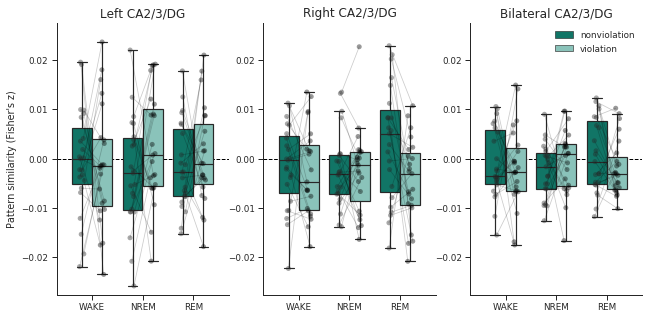

In [57]:
# Raw differentiation: Plot vio,nonvio (boxplot w/ swarm) in CA2/3/DG
roi = 'CA23DG'
mask_list=['left_CA2+3+DG_1.5mm', 'right_CA2+3+DG_1.5mm', 'bilateral_CA2+3+DG_1.5mm']
mask_titles=['Left CA2/3/DG', 'Right CA2/3/DG', 'Bilateral CA2/3/DG']
depVar = "preApostB_z"
condition_order = ['nonvio', 'vio']
group_order=['WAKE', 'NREM', 'REM']
n_groups = 3 #wake,nrem,rem
custom = sns.set_palette(sns.color_palette(two_colors_greens)) #Set custom color palette

n_subplots = len(mask_list)
f, ax = plt.subplots(1, n_subplots, sharey=False, figsize=(n_subplots*3.5,5)) #figsize=(10,5)
for plot in range(0, n_subplots):
    mask = mask_list[plot]
    plot_title = '%s' %(mask_titles[plot])
    plot_data = differentiation[(differentiation['condition']!='vio-nonvio') & (differentiation['mask']==mask)] #select data subset
    if plot == 0:
        display(plot_data['group'].value_counts())
        
    sns.boxplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        palette=custom, ax=ax[plot],
        showfliers = False #ax=ax[plot_coord[plot]]
        )
    
    sns.stripplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        color='black', alpha=0.4, dodge=True, zorder=8, ax=ax[plot]
    )
    
    ax[plot].axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0)
    ax[plot].set(ylim=(-.0275, .0275))
    if plot == 0:
        ax[plot].set_ylabel("Pattern similarity (Fisher's z)")
    else:         
        ax[plot].set(ylabel=None)
    ax[plot].set(xlabel=None)
    ax[plot].set_title(plot_title, fontsize=12)
    if plot == 2:
        h, l = ax[plot].get_legend_handles_labels()
        #ax[plot].legend(h, ['violation', 'nonviolation'], frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
        ax[plot].legend(h, ['nonviolation', 'violation'], frameon=False, loc='upper right')
    else:
        ax[plot].legend().remove()
        
    # Now connect the dots
    vio={}
    nonvio={}
    for gp in range(0,n_groups):
        # for each bar, this gives us the x coordinate (used to jitter dots) and the actual y-axis value
        nonvio[gp] = ax[plot].get_children()[gp*2].get_offsets() #nonvio condition
        vio[gp] = ax[plot].get_children()[gp*2+1].get_offsets() #nvio condition
        
        # plot lines for each subject in this group
        for sub in range(0,len(vio[gp])):
            x = [nonvio[gp][sub][0],vio[gp][sub][0]]
            y = [nonvio[gp][sub][1],vio[gp][sub][1]]
            ax[plot].plot(x, y, color = 'black', alpha=0.2, linewidth = 0.8, linestyle = '-', zorder=5)

# final touches
sns.despine()
plt.show()

# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-and-nonvio_boxwithconnectinglines_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

In [ ]:
# example of how to select data subset
pd.set_option('display.max_rows', None)
x = differentiation[(differentiation['mask']=='right_CA2+3+DG_1.5mm') & 
                    (differentiation['condition'] != 'vio-nonvio') &
                    (differentiation['group'] == 'NREM')]

x

REM     46
NREM    46
WAKE    46
Name: group, dtype: int64

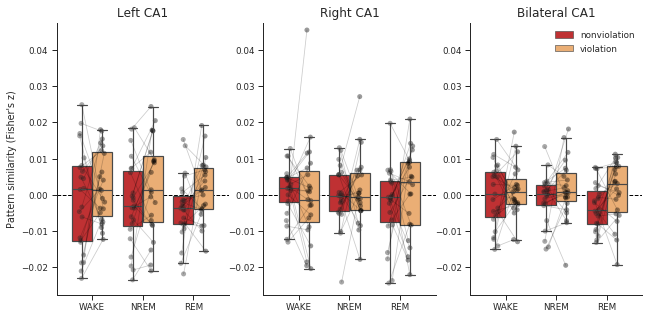

In [58]:
# Raw differentiation: Plot vio,nonvio (boxplot w/ swarm) in CA1
roi = 'CA1'
mask_list=['left_CA1_1.5mm', 'right_CA1_1.5mm', 'bilateral_CA1_1.5mm']
mask_titles=['Left CA1', 'Right CA1', 'Bilateral CA1']
depVar = "preApostB_z"
condition_order = ['nonvio', 'vio']
group_order=['WAKE', 'NREM', 'REM']
n_groups = 3 #wake,nrem,rem
custom = sns.set_palette(sns.color_palette(two_colors_reds)) #Set custom color palette

n_subplots = len(mask_list)
f, ax = plt.subplots(1, n_subplots, sharey=False, figsize=(n_subplots*3.5,5)) #figsize=(10,5)
for plot in range(0, n_subplots):
    mask = mask_list[plot]
    plot_title = '%s' %(mask_titles[plot])
    plot_data = differentiation[(differentiation['condition']!='vio-nonvio') & (differentiation['mask']==mask)] #select data subset
    if plot == 0:
        display(plot_data['group'].value_counts())

    sns.boxplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        palette=custom, ax=ax[plot],
        showfliers = False #ax=ax[plot_coord[plot]]
        )
    
    sns.stripplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        color='black', alpha=0.4, dodge=True, zorder=2, ax=ax[plot] #ax=ax[plot_coord[plot]]
    )
    
    ax[plot].axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0)
    ax[plot].set(ylim=(-.0275, .0475))
    if plot == 0:
        ax[plot].set_ylabel("Pattern similarity (Fisher's z)")
    else:         
        ax[plot].set(ylabel=None)
    ax[plot].set(xlabel=None)
    ax[plot].set_title(plot_title, fontsize=12)
    if plot == 2:
        h, l = ax[plot].get_legend_handles_labels()
        #ax[plot].legend(h, ['violation', 'nonviolation'], frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
        ax[plot].legend(h, ['nonviolation', 'violation'], frameon=False, loc='upper right')
    else:
        ax[plot].legend().remove()
        
    # Now connect the dots
    vio={}
    nonvio={}
    for gp in range(0,n_groups):
        # for each bar, this gives us the x coordinate (used to jitter dots) and the actual y-axis value
        nonvio[gp] = ax[plot].get_children()[gp*2].get_offsets() #nonvio condition
        vio[gp] = ax[plot].get_children()[gp*2+1].get_offsets() #nvio condition
        
        # plot lines for each subject in this group
        for sub in range(0,len(vio[gp])):
            x = [nonvio[gp][sub][0],vio[gp][sub][0]]
            y = [nonvio[gp][sub][1],vio[gp][sub][1]]
            ax[plot].plot(x, y, color = 'black', alpha=0.2, linewidth = 0.8, linestyle = '-', zorder=5)

# final touches
sns.despine()
plt.show()

# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-and-nonvio_boxwithconnectinglines_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

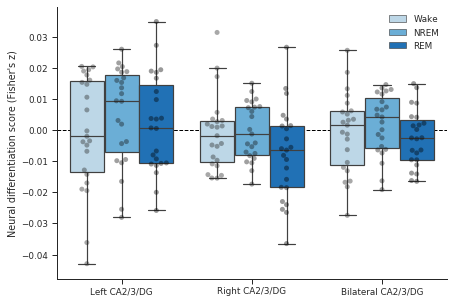

In [16]:
# Raw differentiation: Plot vio-nonvio difference score (BOXPLOT w/ SWARM) in CA2/3/DG
roi = 'CA23DG'
plot_title = 'CA2/3/DG'
mask_list=['left_CA2+3+DG_1.5mm', 'right_CA2+3+DG_1.5mm', 'bilateral_CA2+3+DG_1.5mm']
depVar = "preApostB_z"
condition_order = ['vio', 'nonvio']
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette


difference_score=differentiation[(differentiation['condition']=='vio-nonvio')]
plot_data = difference_score[ 
                           (difference_score['mask']=='left_CA2+3+DG_1.5mm') |
                           (difference_score['mask']=='right_CA2+3+DG_1.5mm') |
                           (difference_score['mask']=='bilateral_CA2+3+DG_1.5mm')] #select data subset
n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

# ax.set(ylim=(-.02, .02))
#ax.set_title(plot_title, fontsize=12)
#ax.legend().remove()
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='upper right') #, bbox_to_anchor=(1, 1)

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Neural differentiation score (Fisher's z)")
#ax.set(xticks=[])
ax.set(xticklabels=['Left CA2/3/DG', 'Right CA2/3/DG', 'Bilateral CA2/3/DG'])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-minus-nonvio_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

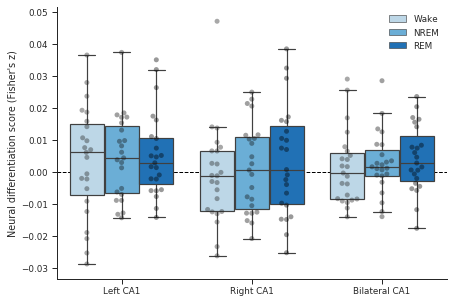

In [17]:
# Raw differentiation: Plot vio-nonvio difference score (BOXPLOT w/ SWARM) in CA1
roi = 'CA1'
plot_title = 'CA1'
mask_list=['left_CA1_1.5mm', 'right_CA1_1.5mm', 'bilateral_CA1_1.5mm']
depVar = "preApostB_z"
condition_order = ['vio', 'nonvio']
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette


difference_score=differentiation[(differentiation['condition']=='vio-nonvio')]
plot_data = difference_score[ 
                           (difference_score['mask']=='left_CA1_1.5mm') |
                           (difference_score['mask']=='right_CA1_1.5mm') |
                           (difference_score['mask']=='bilateral_CA1_1.5mm')] #select data subset
n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

# ax.set(ylim=(-.02, .02))
#ax.set_title(plot_title, fontsize=12)
#ax.legend().remove()
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='upper right') #bbox_to_anchor=(1, 1)

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Neural differentiation score (Fisher's z)")
ax.set(xticklabels=['Left CA1', 'Right CA1', 'Bilateral CA1'])
#ax.set(xticks=[])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-minus-nonvio_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

REM     46
NREM    46
WAKE    46
Name: group, dtype: int64

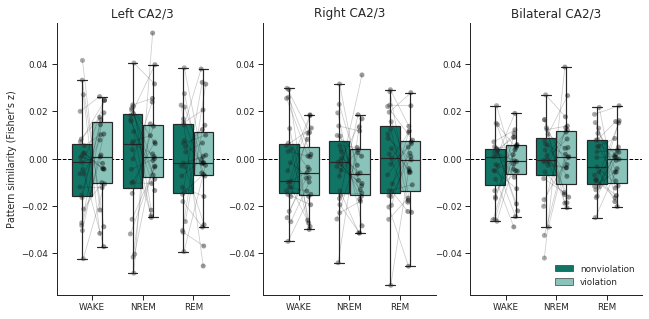

In [66]:
# Raw differentiation: Plot vio,nonvio (boxplot w/ swarm) in CA2/3 separately
roi = 'CA23only'
mask_list=['left_CA2+3_1.5mm', 'right_CA2+3_1.5mm', 'bilateral_CA2+3_1.5mm']
mask_titles=['Left CA2/3', 'Right CA2/3', 'Bilateral CA2/3']
depVar = "preApostB_z"
condition_order = ['nonvio', 'vio']
group_order=['WAKE', 'NREM', 'REM']
n_groups = 3 #wake,nrem,rem
custom = sns.set_palette(sns.color_palette(two_colors_greens)) #Set custom color palette

n_subplots = len(mask_list)
f, ax = plt.subplots(1, n_subplots, sharey=False, figsize=(n_subplots*3.5,5)) #figsize=(10,5)
for plot in range(0, n_subplots):
    mask = mask_list[plot]
    plot_title = '%s' %(mask_titles[plot])
    plot_data = differentiation[(differentiation['condition']!='vio-nonvio') & (differentiation['mask']==mask)] #select data subset
    if plot == 0:
        display(plot_data['group'].value_counts())
        
    sns.boxplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        palette=custom, ax=ax[plot],
        showfliers = False #ax=ax[plot_coord[plot]]
        )
    
    sns.stripplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        color='black', alpha=0.4, dodge=True, zorder=8, ax=ax[plot]
    )
    
    ax[plot].axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0)
    ax[plot].set(ylim=(-.0575, .0575))
    if plot == 0:
        ax[plot].set_ylabel("Pattern similarity (Fisher's z)")
    else:         
        ax[plot].set(ylabel=None)
    ax[plot].set(xlabel=None)
    ax[plot].set_title(plot_title, fontsize=12)
    if plot == 2:
        h, l = ax[plot].get_legend_handles_labels()
        ax[plot].legend(h, ['nonviolation', 'violation'], frameon=False, loc='lower right')
    else:
        ax[plot].legend().remove()
        
    # Now connect the dots
    vio={}
    nonvio={}
    for gp in range(0,n_groups):
        # for each bar, this gives us the x coordinate (used to jitter dots) and the actual y-axis value
        nonvio[gp] = ax[plot].get_children()[gp*2].get_offsets() #nonvio condition
        vio[gp] = ax[plot].get_children()[gp*2+1].get_offsets() #nvio condition
        
        # plot lines for each subject in this group
        for sub in range(0,len(vio[gp])):
            x = [nonvio[gp][sub][0],vio[gp][sub][0]]
            y = [nonvio[gp][sub][1],vio[gp][sub][1]]
            ax[plot].plot(x, y, color = 'black', alpha=0.2, linewidth = 0.8, linestyle = '-', zorder=5)

# final touches
sns.despine()
plt.show()

# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-and-nonvio_boxwithconnectinglines_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

REM     46
NREM    46
WAKE    46
Name: group, dtype: int64

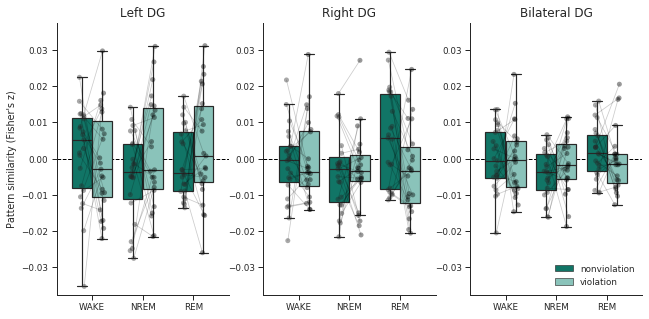

In [68]:
# Raw differentiation: Plot vio,nonvio (boxplot w/ swarm) in DG only
roi = 'DGonly'
mask_list=['left_DG_1.5mm', 'right_DG_1.5mm', 'bilateral_DG_1.5mm']
mask_titles=['Left DG', 'Right DG', 'Bilateral DG']
depVar = "preApostB_z"
condition_order = ['nonvio', 'vio']
group_order=['WAKE', 'NREM', 'REM']
n_groups = 3 #wake,nrem,rem
custom = sns.set_palette(sns.color_palette(two_colors_greens)) #Set custom color palette

n_subplots = len(mask_list)
f, ax = plt.subplots(1, n_subplots, sharey=False, figsize=(n_subplots*3.5,5)) #figsize=(10,5)
for plot in range(0, n_subplots):
    mask = mask_list[plot]
    plot_title = '%s' %(mask_titles[plot])
    plot_data = differentiation[(differentiation['condition']!='vio-nonvio') & (differentiation['mask']==mask)] #select data subset
    if plot == 0:
        display(plot_data['group'].value_counts())
        
    sns.boxplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        palette=custom, ax=ax[plot],
        showfliers = False #ax=ax[plot_coord[plot]]
        )
    
    sns.stripplot(
        data=plot_data, 
        x="group", order=group_order,
        y=depVar, 
        hue="condition", hue_order=condition_order,
        color='black', alpha=0.4, dodge=True, zorder=8, ax=ax[plot]
    )
    
    ax[plot].axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0)
    ax[plot].set(ylim=(-.0375, .0375))
    if plot == 0:
        ax[plot].set_ylabel("Pattern similarity (Fisher's z)")
    else:         
        ax[plot].set(ylabel=None)
    ax[plot].set(xlabel=None)
    ax[plot].set_title(plot_title, fontsize=12)
    if plot == 2:
        h, l = ax[plot].get_legend_handles_labels()
        ax[plot].legend(h, ['nonviolation', 'violation'], frameon=False, loc='lower right')
    else:
        ax[plot].legend().remove()
        
    # Now connect the dots
    vio={}
    nonvio={}
    for gp in range(0,n_groups):
        # for each bar, this gives us the x coordinate (used to jitter dots) and the actual y-axis value
        nonvio[gp] = ax[plot].get_children()[gp*2].get_offsets() #nonvio condition
        vio[gp] = ax[plot].get_children()[gp*2+1].get_offsets() #nvio condition
        
        # plot lines for each subject in this group
        for sub in range(0,len(vio[gp])):
            x = [nonvio[gp][sub][0],vio[gp][sub][0]]
            y = [nonvio[gp][sub][1],vio[gp][sub][1]]
            ax[plot].plot(x, y, color = 'black', alpha=0.2, linewidth = 0.8, linestyle = '-', zorder=5)

# final touches
sns.despine()
plt.show()

# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-and-nonvio_boxwithconnectinglines_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

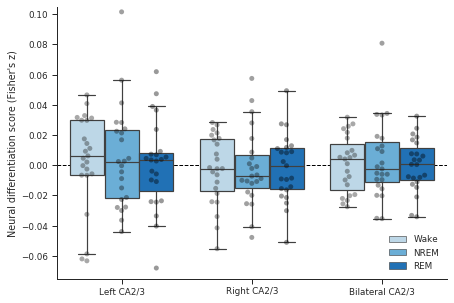

In [74]:
# Raw differentiation: Plot vio-nonvio difference score (BOXPLOT w/ SWARM) in CA2/3 only
roi = 'CA23only'
mask_list=['left_CA2+3_1.5mm', 'right_CA2+3_1.5mm', 'bilateral_CA2+3_1.5mm']
depVar = "preApostB_z"
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette


difference_score=differentiation[(differentiation['condition']=='vio-nonvio')]
plot_data = difference_score[ 
                           (difference_score['mask']=='left_CA2+3_1.5mm') |
                           (difference_score['mask']=='right_CA2+3_1.5mm') |
                           (difference_score['mask']=='bilateral_CA2+3_1.5mm')] #select data subset
n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

ax.set(ylim=(-.075, .105))
#ax.set_title(plot_title, fontsize=12)
#ax.legend().remove()
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='lower right') #bbox_to_anchor=(1, 1)

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Neural differentiation score (Fisher's z)")
ax.set(xticklabels=['Left CA2/3', 'Right CA2/3', 'Bilateral CA2/3'])
#ax.set(xticks=[])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-minus-nonvio_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

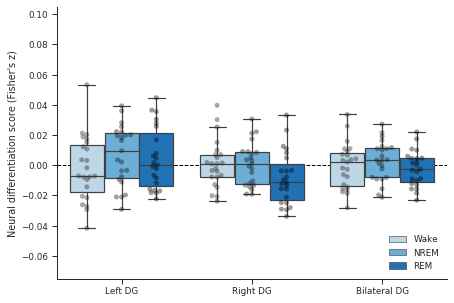

In [75]:
# Raw differentiation: Plot vio-nonvio difference score (BOXPLOT w/ SWARM) in DG only
roi = 'DGonly'
mask_list=['left_DG_1.5mm', 'right_DG_1.5mm', 'bilateral_DG_1.5mm']
depVar = "preApostB_z"
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette


difference_score=differentiation[(differentiation['condition']=='vio-nonvio')]
plot_data = difference_score[ 
                           (difference_score['mask']=='left_DG_1.5mm') |
                           (difference_score['mask']=='right_DG_1.5mm') |
                           (difference_score['mask']=='bilateral_DG_1.5mm')] #select data subset
n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

ax.set(ylim=(-.075, .105))
#ax.set_title(plot_title, fontsize=12)
#ax.legend().remove()
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='lower right') #bbox_to_anchor=(1, 1)

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Neural differentiation score (Fisher's z)")
ax.set(xticklabels=['Left DG', 'Right DG', 'Bilateral DG'])
#ax.set(xticks=[])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'differentiation_vio-minus-nonvio_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

## Bprediction-differentiation plots
- Bprediction-differentiation in each ROI (left, right, bilateral CA1 and CA2/3/DG)
- also in CA2/3 and DG separately
- always use the z-transformed values (BpredictDiff_z) for plotting and statistics

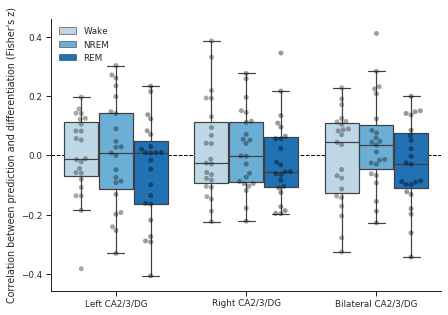

In [21]:
# Bprediction-differentiation: BOXPLOT w/ SWARM in CA2/3/DG
roi = 'CA23DG'
mask_list=['left_CA2+3+DG_1.5mm', 'right_CA2+3+DG_1.5mm', 'bilateral_CA2+3+DG_1.5mm']
depVar = "BpredictDiff_z"
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette

plot_data = Bprediction_diff[
                             (Bprediction_diff['mask']=='left_CA2+3+DG_1.5mm') |   
                             (Bprediction_diff['mask']=='right_CA2+3+DG_1.5mm') |
                             (Bprediction_diff['mask']=='bilateral_CA2+3+DG_1.5mm')] #select data subset

n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

# ax.set(ylim=(-.02, .02))
#ax.set_title(plot_title, fontsize=12)
#ax.legend().remove()
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='upper left') #bbox_to_anchor=(1, 1)

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Correlation between prediction and differentiation (Fisher's z)")
#ax.set(xticks=[])
ax.set(xticklabels=['Left CA2/3/DG', 'Right CA2/3/DG', 'Bilateral CA2/3/DG'])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'Bprediction_differentiation_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

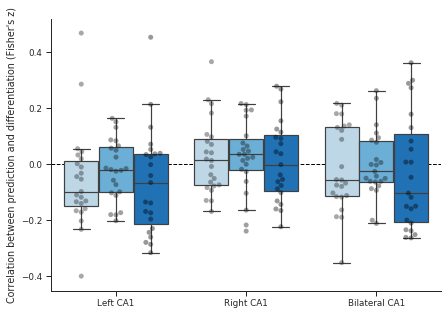

In [22]:
# Bprediction-differentiation: BOXPLOT w/ SWARM in CA1
roi = 'CA1'
mask_list=['left_CA1_1.5mm', 'right_CA1_1.5mm', 'bilateral_CA1_1.5mm']
depVar = "BpredictDiff_z"
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette

plot_data = Bprediction_diff[
                             (Bprediction_diff['mask']=='left_CA1_1.5mm') |   
                             (Bprediction_diff['mask']=='right_CA1_1.5mm') |
                             (Bprediction_diff['mask']=='bilateral_CA1_1.5mm')] #select data subset

n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

# ax.set(ylim=(-.02, .02))
#ax.set_title(plot_title, fontsize=12)
ax.legend().remove()
h, l = ax.get_legend_handles_labels()
#ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Correlation between prediction and differentiation (Fisher's z)")
#ax.set(xticks=[])
ax.set(xticklabels=['Left CA1', 'Right CA1', 'Bilateral CA1'])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'Bprediction_differentiation_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

In [29]:
saving_figures = 1

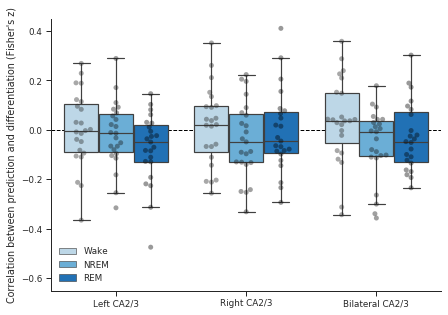

In [30]:
# Bprediction-differentiation: BOXPLOT w/ SWARM in CA2/3 only
roi = 'CA23only'
mask_list=['left_CA2+3_1.5mm', 'right_CA2+3_1.5mm', 'bilateral_CA2+3_1.5mm']
depVar = "BpredictDiff_z"
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette

plot_data = Bprediction_diff[
                             (Bprediction_diff['mask']=='left_CA2+3_1.5mm') |   
                             (Bprediction_diff['mask']=='right_CA2+3_1.5mm') |
                             (Bprediction_diff['mask']=='bilateral_CA2+3_1.5mm')] #select data subset

n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

ax.set(ylim=(-.65, .45))
#ax.set_title(plot_title, fontsize=12)
#ax.legend().remove()
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='lower left') #bbox_to_anchor=(1, 1)

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Correlation between prediction and differentiation (Fisher's z)")
#ax.set(xticks=[])
ax.set(xticklabels=['Left CA2/3', 'Right CA2/3', 'Bilateral CA2/3'])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'Bprediction_differentiation_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)

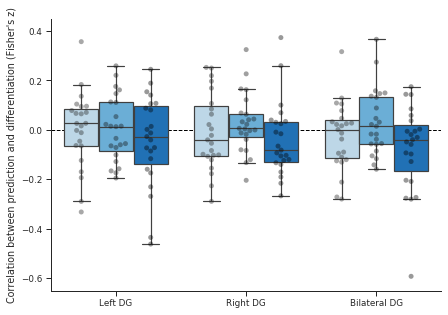

In [31]:
# Bprediction-differentiation: BOXPLOT w/ SWARM in DG only
roi = 'DGonly'
mask_list=['left_DG_1.5mm', 'right_DG_1.5mm', 'bilateral_DG_1.5mm']
depVar = "BpredictDiff_z"
group_order=['WAKE', 'NREM', 'REM']
custom = sns.set_palette(sns.color_palette(three_colors_blues)) #Set custom color palette

plot_data = Bprediction_diff[
                             (Bprediction_diff['mask']=='left_DG_1.5mm') |   
                             (Bprediction_diff['mask']=='right_DG_1.5mm') |
                             (Bprediction_diff['mask']=='bilateral_DG_1.5mm')] #select data subset

n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*7,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.swarmplot(
    data=plot_data, 
    x="mask", order=mask_list,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

ax.set(ylim=(-.65, .45))
#ax.set_title(plot_title, fontsize=12)
ax.legend().remove()
#h, l = ax.get_legend_handles_labels()
#ax.legend(h[0:3], ['Wake', 'NREM', 'REM'], frameon=False, loc='lower right') #bbox_to_anchor=(1, 1)

# final touches
plt.axhline(y=0, linewidth=1, color='black', linestyle='--', zorder=0) 
sns.despine()
ax.set(xlabel=None)
ax.set(ylabel="Correlation between prediction and differentiation (Fisher's z)")
#ax.set(xticks=[])
ax.set(xticklabels=['Left DG', 'Right DG', 'Bilateral DG'])
plt.show()


# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'Bprediction_differentiation_box_%s_N=%s.png' %(roi,n_subjects), format='png', dpi=500)